In [66]:
# importing required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, make_scorer
from imblearn.over_sampling import SMOTENC
from xgboost import XGBClassifier
# !pip install xgboost

In [52]:
# importing or loading the dataset
dataset = pd.read_csv('Stock_data.csv')

num_dataset = dataset.select_dtypes(include=[np.number])
# Multivariate Analysis

# Correlation matrix
correlation_matrix = num_dataset.corr()

def rank_columns_by_correlation(df, threshold=0.9):
    # Calculating correlation matrix
    corr_matrix = df.corr()
    # Initializing a list to hold the tuples (col1, col2, correlation)
    correlations = []
    # Iterating over the correlation matrix
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):  # avoiding duplicate and self-correlation
            # Including only correlations above the specified threshold
            if abs(corr_matrix.iloc[i, j]) > threshold:
                correlations.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

    # Sorting the list by absolute correlation in descending order
    sorted_correlations = sorted(correlations, key=lambda x: abs(x[2]), reverse=True)
    correlation_df = pd.DataFrame(sorted_correlations, columns=['Column1', 'Column2', 'Correlation'])
    return correlation_df

top_correlations = rank_columns_by_correlation(num_dataset, 0.7)

# Remove highly correlated columns
columns_to_remove = top_correlations["Column2"].unique()
dataset.drop(columns_to_remove, axis="columns", inplace=True)

print(len(dataset.columns))

102


In [53]:
# First let's leave out the last year's data as future test data, and 2021's data as validation data
training_data = dataset.loc[(dataset["year"] != 2022) & (dataset["year"] != 2021)]
validation_data = dataset.loc[dataset["year"] == 2021]
testing_data = dataset.loc[dataset["year"] == 2022]


# Predictor - Target Split
X_train = training_data.drop("dps_change_next_year", axis="columns")
y_train = training_data["dps_change_next_year"]
X_test = testing_data.drop("dps_change_next_year", axis="columns")
y_test = testing_data["dps_change_next_year"]
X_validate = validation_data.drop("dps_change_next_year", axis="columns")
y_validate = validation_data["dps_change_next_year"]

In [54]:
# Encoding our categorical features - The reason we are encoding them is that not all algorithms support
# categorical predictors.

# Define categorical features
categorical_columns = ["industry", "sector", "symbol"]
other_columns = [col for col in X_train.columns if col not in categorical_columns]

# Label encode categorical features with many categories
column_transformer = ColumnTransformer(
    transformers=[
        ('categorical', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_columns)
    ],
    remainder='passthrough'
)

X_train_transformed = column_transformer.fit_transform(X_train)
X_validate_transformed = column_transformer.transform(X_validate)
X_test_transformed = column_transformer.transform(X_test)

# Note: after transformation, the output will be a numpy array and column orders will be changed.
X_train_transformed = pd.DataFrame(X_train_transformed, columns=categorical_columns + other_columns)
X_validate_transformed = pd.DataFrame(X_validate_transformed, columns=categorical_columns + other_columns)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=categorical_columns + other_columns)

# Check our data type
X_train_transformed.info(verbose=True, show_counts=True)

# Let's change our data types back to their original forms - However, this time, categorical variables have become
# number like strings
cols_to_convert = {'industry': 'str', 'sector': 'str', 'symbol': 'str', 'year': 'int'}
X_train_transformed = X_train_transformed.astype(cols_to_convert)
X_validate_transformed = X_validate_transformed.astype(cols_to_convert)
X_test_transformed = X_test_transformed.astype(cols_to_convert)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840 entries, 0 to 3839
Data columns (total 101 columns):
 #    Column                                                Non-Null Count  Dtype  
---   ------                                                --------------  -----  
 0    industry                                              3840 non-null   float64
 1    sector                                                3840 non-null   float64
 2    symbol                                                3840 non-null   float64
 3    year                                                  3840 non-null   float64
 4    adjDividend                                           3840 non-null   float64
 5    dps_growth                                            3840 non-null   float64
 6    dps_growth_rate                                       3840 non-null   float64
 7    companyRating                                         3840 non-null   float64
 8    companyRating_percentage_change               

In [55]:
# Check data imbalance
# Let's add target back to our dataset for further analysis
training_data_transformed = pd.concat([X_train_transformed, y_train], axis=1)
training_data_transformed["dps_change_next_year"].value_counts()

# Let's do some over sampling

# Perform oversampling using SMOTE
categorical_indices = [X_train_transformed.columns.get_loc(col) for col in categorical_columns]
smote = SMOTENC(random_state=1, categorical_features=categorical_indices)

X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train_transformed, y_train)
# Check our training data
pd.DataFrame(y_train_oversampled)["dps_change_next_year"].value_counts()
X_train_oversampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7246 entries, 0 to 7245
Columns: 101 entries, industry to enterpriseValueMultiple_percentage_change
dtypes: float64(97), int64(1), object(3)
memory usage: 5.6+ MB


In [56]:
# performing preprocessing part
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train_pca = sc.fit_transform(X_train_oversampled)
X_validate_pca = sc.transform(X_validate_transformed)
X_test_pca = sc.transform(X_test_transformed)


Text(0, 0.5, 'cumulative explained variance')

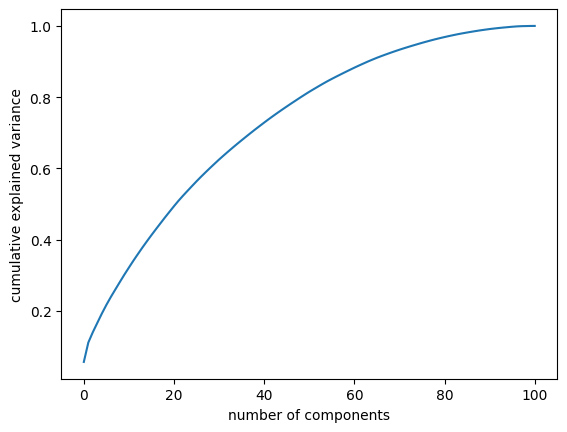

In [57]:
# Applying PCA function on training
# and testing set of X component
from sklearn.decomposition import PCA

pca = PCA().fit(X_train_pca)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')


In [60]:
pca = PCA(n_components = 0.95)

X_train_pca = pca.fit_transform(X_train_pca)
X_validate_pca = pca.transform(X_validate_pca)
X_test_pca = pca.transform(X_test_pca)

explained_variance = pca.explained_variance_ratio_


In [61]:
X_train_temp = X_train_pca.copy()
X_validate_temp = X_validate_pca.copy()

# First, evaluate performance using all features
randomForestModel = RandomForestClassifier(max_features=None)
randomForestModel.fit(X_train_pca, y_train_oversampled)
# Predict probabilities on test data
y_pred_probs = randomForestModel.predict_proba(X_validate_temp)[:, 1]
# Compute ROC score
roc_score = roc_auc_score(y_test, y_pred_probs)
# Append the result to the result dataframe
print(f"Feature_Removed: None, ROC_AUC_Score: {roc_score}")


Feature_Removed: None, ROC_AUC_Score: 0.5444992690058479


In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [68]:
from sklearn.preprocessing import LabelEncoder

# Assuming y_train_oversampled and y_validate contain the original categorical labels
label_encoder = LabelEncoder()

# Fit the label encoder and transform the labels to integers
y_train_encoded = label_encoder.fit_transform(y_train_oversampled)
y_validate_encoded = label_encoder.transform(y_validate)

In [70]:
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    model.fit(X_train_pca, y_train_encoded)
    y_pred = model.predict(X_validate_pca)
    y_pred_prob = model.predict_proba(X_validate_pca)[:, 1]  # probabilities for the positive class
    accuracy = accuracy_score(y_validate_encoded, y_pred)
    auc_roc = roc_auc_score(y_validate_encoded, y_pred_prob)
    results[name] = (accuracy, auc_roc)

# Print the accuracy and AUC-ROC of each model
for name, (accuracy, auc_roc) in results.items():
    print(f"{name} - Accuracy: {accuracy:.4f}, AUC-ROC: {auc_roc:.4f}")


Random Forest - Accuracy: 0.9417, AUC-ROC: 0.7115
Logistic Regression - Accuracy: 0.8146, AUC-ROC: 0.8493
Decision Tree - Accuracy: 0.7250, AUC-ROC: 0.4915
KNN - Accuracy: 0.7937, AUC-ROC: 0.6822
XGBoost - Accuracy: 0.8333, AUC-ROC: 0.5511
